# Convergence of estimators on Ishigami

In this example, we present the convergence of the sensitivity indices of the Ishigami test function.

We compare different estimators.
* Sampling methods with different estimators: Saltelli, Mauntz-Kucherenko, Martinez, Jansen,
* Sampling methods with different design of experiments: Monte-Carlo, LHS, Quasi-Monte-Carlo,
* Polynomial chaos (TODO).

In [1]:
import openturns as ot
import otbenchmark as otb
import openturns.viewer as otv
import numpy as np

When we estimate Sobol' indices, we may encounter the following warning messages:
```
WRN - The estimated first order Sobol index (2) is greater than its total order index . You may increase the sampling size.
WRN - The estimated total order Sobol index (2) is lesser than first order index . You may increase the sampling size.
```
Lots of these messages are printed in the current Notebook. This is why we disable them with:

In [2]:
ot.Log.Show(ot.Log.NONE)

In [3]:
problem = otb.IshigamiSensitivity()
problem

In [4]:
print(problem)

name = Ishigami
distribution = ComposedDistribution(Uniform(a = -3.14159, b = 3.14159), Uniform(a = -3.14159, b = 3.14159), Uniform(a = -3.14159, b = 3.14159), IndependentCopula(dimension = 3))
function = ParametricEvaluation([X1,X2,X3,a,b]->[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)], parameters positions=[3,4], parameters=[a : 7, b : 0.1], input positions=[0,1,2])
firstOrderIndices = [0.313905,0.442411,0]
totalOrderIndices = [0.557589,0.442411,0.243684]


In [5]:
distribution = problem.getInputDistribution()
model = problem.getFunction()

In [6]:
# Exact first and total order
exact_first_order = problem.getFirstOrderIndices()
exact_first_order

class=Point name=Unnamed dimension=3 values=[0.313905,0.442411,0]

In [7]:
exact_total_order = problem.getTotalOrderIndices()
exact_total_order

class=Point name=Unnamed dimension=3 values=[0.557589,0.442411,0.243684]

## Perform sensitivity analysis

In [8]:
# Create X/Y data
ot.RandomGenerator.SetSeed(0)
size = 10000
inputDesign = ot.SobolIndicesExperiment(distribution, size).generate()
outputDesign = model(inputDesign)

In [9]:
# Compute first order indices using the Saltelli estimator
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)
computed_first_order = sensitivityAnalysis.getFirstOrderIndices()
computed_total_order = sensitivityAnalysis.getTotalOrderIndices()

In [10]:
# Compare with exact results
print("Sample size : ", size)
# First order
# Compute absolute error (the LRE cannot be computed,
# because S can be zero)
print("Computed first order = ", computed_first_order)
print("Exact first order    = ", exact_first_order)
# Total order
print("Computed total order = ", computed_total_order)
print("Exact total order    = ", exact_total_order)

Sample size :  10000
Computed first order =  [0.302745,0.460846,0.0066916]
Exact first order    =  [0.313905,0.442411,0]
Computed total order =  [0.574996,0.427126,0.256689]
Exact total order    =  [0.557589,0.442411,0.243684]


In [11]:
dimension = distribution.getDimension()

Compute componentwise absolute error.

In [12]:
first_order_AE = ot.Point(np.abs(exact_first_order - computed_first_order))
total_order_AE = ot.Point(np.abs(exact_total_order - computed_total_order))

In [13]:
print("Absolute error")
for i in range(dimension):
    print(
        "AE(S%d) = %.4f, AE(T%d) = %.4f" % (i, first_order_AE[i], i, total_order_AE[i])
    )

Absolute error
AE(S0) = 0.0112, AE(T0) = 0.0174
AE(S1) = 0.0184, AE(T1) = 0.0153
AE(S2) = 0.0067, AE(T2) = 0.0130


Estimator: Saltelli
Estimator: Martinez
Estimator: Jansen
Estimator: MauntzKucherenko


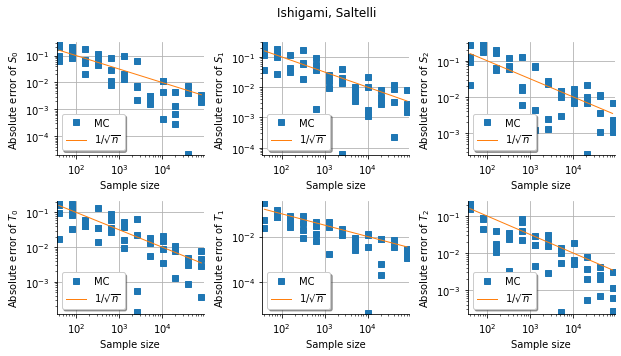

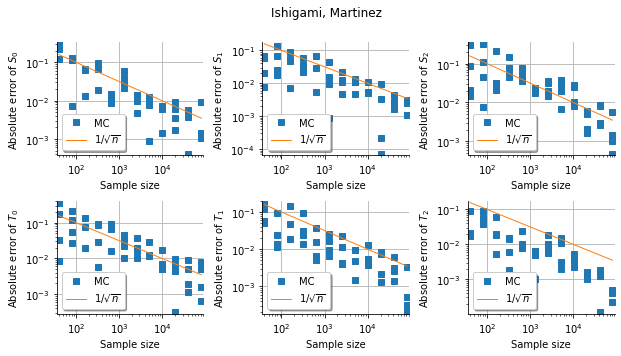

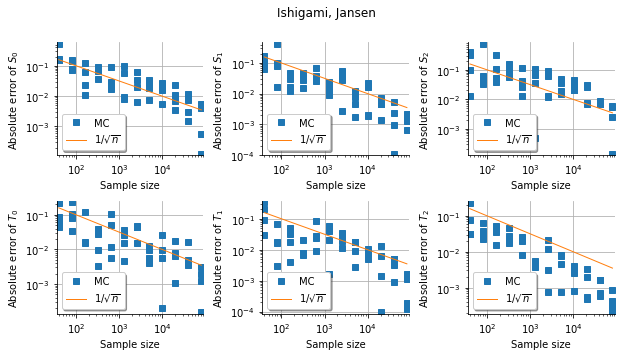

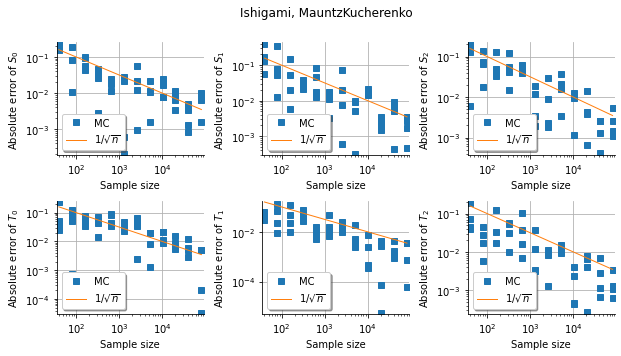

In [14]:
metaSAAlgorithm = otb.SensitivityBenchmarkMetaAlgorithm(problem)
for estimator in ["Saltelli", "Martinez", "Jansen", "MauntzKucherenko"]:
    print("Estimator:", estimator)
    benchmark = otb.SensitivityConvergenceBenchmark(
        problem,
        metaSAAlgorithm,
        numberOfRepetitions=4,
        maximum_elapsed_time=2.0,
        sample_size_initial=20,
        estimator=estimator,
    )
    grid = benchmark.plotConvergenceGrid(verbose=False)
    view = otv.View(grid)
    figure = view.getFigure()
    _ = figure.suptitle("%s, %s" % (problem.getName(), estimator))
    figure.set_figwidth(10.0)
    figure.set_figheight(5.0)
    figure.subplots_adjust(wspace=0.4, hspace=0.4)

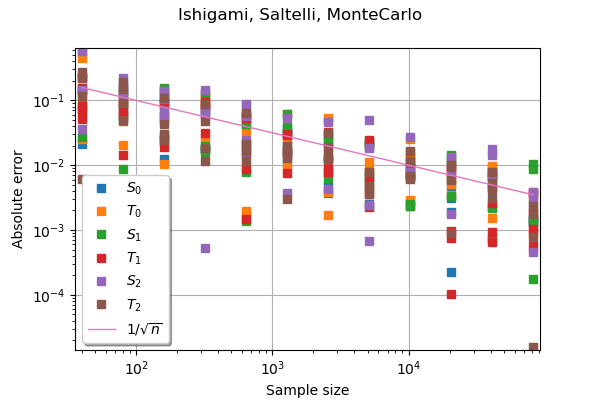

In [15]:
benchmark = otb.SensitivityConvergenceBenchmark(
    problem,
    metaSAAlgorithm,
    numberOfRepetitions=4,
    maximum_elapsed_time=2.0,
    sample_size_initial=20,
    estimator="Saltelli",
    sampling_method="MonteCarlo",
)
benchmark.plotConvergenceCurve()

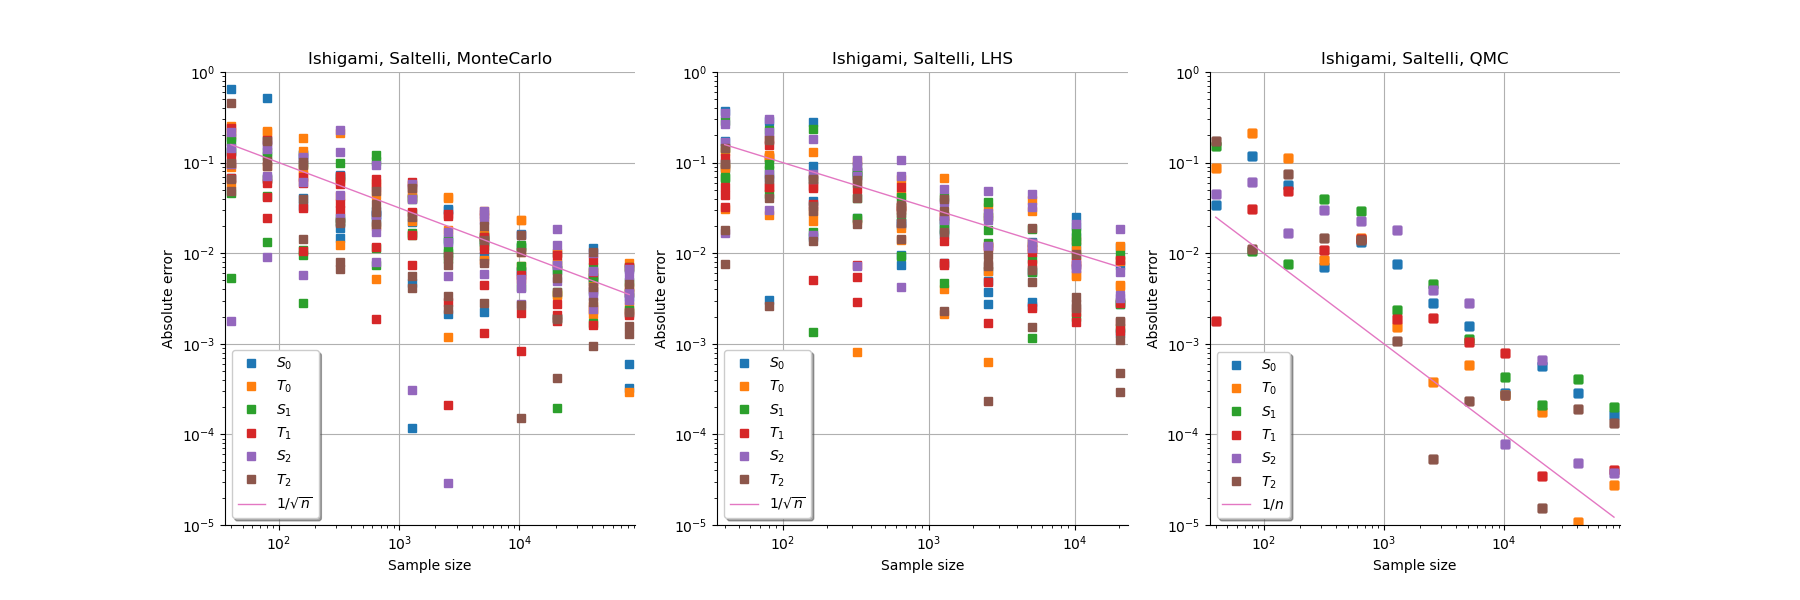

In [16]:
grid = ot.GridLayout(1, 3)
maximum_absolute_error = 1.0
minimum_absolute_error = 1.0e-5
sampling_method_list = ["MonteCarlo", "LHS", "QMC"]
for sampling_method_index in range(3):
    sampling_method = sampling_method_list[sampling_method_index]
    benchmark = otb.SensitivityConvergenceBenchmark(
        problem,
        metaSAAlgorithm,
        numberOfRepetitions=4,
        maximum_elapsed_time=2.0,
        sample_size_initial=20,
        estimator="Saltelli",
        sampling_method=sampling_method,
    )
    graph = benchmark.plotConvergenceCurve()
    # Change bounding box
    box = graph.getBoundingBox()
    bound = box.getLowerBound()
    bound[1] = minimum_absolute_error
    box.setLowerBound(bound)
    bound = box.getUpperBound()
    bound[1] = maximum_absolute_error
    box.setUpperBound(bound)
    graph.setBoundingBox(box)
    grid.setGraph(0, sampling_method_index, graph)
grid